In [1]:
import numpy as np
from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Video
from time import time as timer

# --- 1D electrostatic Vlasov-Poisson simulation ---
def vlasov_simulation(flag_init="linear-Landau"):
    Nx, Nv = 128, 256
    Lx, Lv = 10 * np.pi, 5.0
    dx, dv = Lx / Nx, 2 * Lv / (Nv - 1)
    x = np.linspace(0, Lx, Nx, endpoint=False)
    v = np.linspace(-Lv, Lv, Nv)
    X, V = np.meshgrid(x, v, indexing='xy')

    dt = 0.25
    nt = 400
    nskip = 2
    nsave = (nt - 1) // nskip + 1

    kx = fftfreq(Nx, d=dx) * 2 * np.pi
    kv = fftfreq(Nv, d=dv) * 2 * np.pi
    ksq_inv = np.divide(1.0, kx**2, where=(kx != 0.0))
    fmx = np.exp(-0.5 * v**2) / np.sqrt(2 * np.pi)

    # --- Initial conditions ---
    np.random.seed(0)
    if flag_init == "linear-Landau":
        ampl = 1e-3
        f0_v = fmx.copy()
        f = f0_v[:, None] + ampl * np.cos(4 * np.pi * x / Lx)[None, :] * fmx[:, None]

    elif flag_init == "nonlinear-Landau":
        ampl = 0.2
        f0_v = fmx.copy()
        f = f0_v[:, None] + ampl * np.cos(4 * np.pi * x / Lx)[None, :] * fmx[:, None]

    elif flag_init == "bump-on-tail":
        ampl = 1e-3
        nb, vb, vtb = 0.2, 2.0, 0.3
        bump = np.exp(-0.5 * ((v - vb) / vtb)**2) / np.sqrt(2 * np.pi * vtb**2)
        f0_v = (1.0 - nb) * fmx + nb * bump
        f = np.zeros((Nv, Nx))
        rand_phases = np.random.rand(Nx // 4)
        for ik in range(1, Nx // 4):
            phase = 2 * np.pi * rand_phases[ik]
            f += ampl * np.cos(2 * np.pi * (ik * x / Lx + phase))[None, :] * fmx[:, None]
        f += f0_v[:, None]
    else:
        raise ValueError(f"Unknown flag_init: {flag_init}")

    f0 = f0_v[:, None] # Electron equilibrium distribution f_e0(v)
                       # n_e0 = \int f_e0(v) dv = 1.0 from normalization

    def poisson_solver(f): # - (d/dx)^2 phi = rho
        ne = np.sum(f, axis=0) * dv # Electron density n_e
        rho = 1.0 - ne              # Charge density rho = e(n_i0 - n_e)
        rho_k = fft(rho)
        phi_k = rho_k * ksq_inv
        phi = np.real(ifft(phi_k))  # Electrostatic potential phi
        E_k = -1j * kx * phi_k
        E = np.real(ifft(E_k))      # Electric field E = - d(phi)/dx
        return rho, phi, E

    def time_advance_in_x(f, dt): # Solve df/dt + v * df/dx = 0
        f_hat = fft(f, axis=1)
        phase = np.exp(-1j * kx[None,:] * v[:,None] * dt)
        f_new = np.real(ifft(f_hat * phase, axis=1))
        rho, phi, E = poisson_solver(f_new)
        return f_new, rho, phi, E

    def time_advance_in_v(f, E, dt): # Solve df/dt - E * df/dv = 0
        f_hat = fft(f, axis=0)
        phase = np.exp(+1j * kv[:,None] * E[None,:] * dt)
        f_new = np.real(ifft(f_hat * phase, axis=0))
        return f_new

    t_all, f_all = [], []
    rho_all, phi_all, E_all = [], [], []

    rho, phi, E = poisson_solver(f)
    t=0.0
    # --- Time integration loop ---
    for _ in range(nsave):
        t_all.append(t)
        f_all.append(f.copy())
        rho_all.append(rho.copy())
        phi_all.append(phi.copy())
        E_all.append(E.copy())
        for _ in range(nskip):
            f, rho, phi, E = time_advance_in_x(f, dt / 2)
            f = time_advance_in_v(f, E, dt)
            f, rho, phi, E = time_advance_in_x(f, dt / 2)
            t = t + dt

    t_all = np.array(t_all)
    f_all = np.array(f_all)
    field_all = (np.array(rho_all), np.array(phi_all), np.array(E_all))
    return t_all, f_all, field_all, f0, x, v

# --- Run the simulation ---
elt0 = timer()
print("Start 1D Vlasov simulation.")
t_all, f_all, field_all, f0, x, v = vlasov_simulation(flag_init="bump-on-tail")
print("Simulation complete.")
elt1 = timer(); print("Elapsed time [sec] :", elt1 - elt0)
print(t_all.shape, f_all.shape, x.shape, v.shape)

Start 1D Vlasov simulation.
Simulation complete.
Elapsed time [sec] : 13.469694375991821
(200,) (200, 256, 128) (128,) (256,)


t ≈ 0.00, index = 0


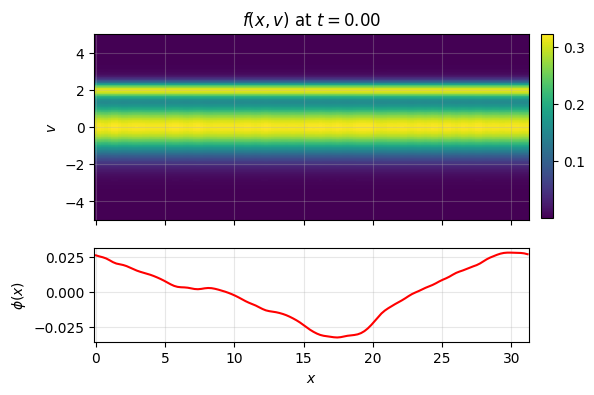

t ≈ 10.00, index = 20


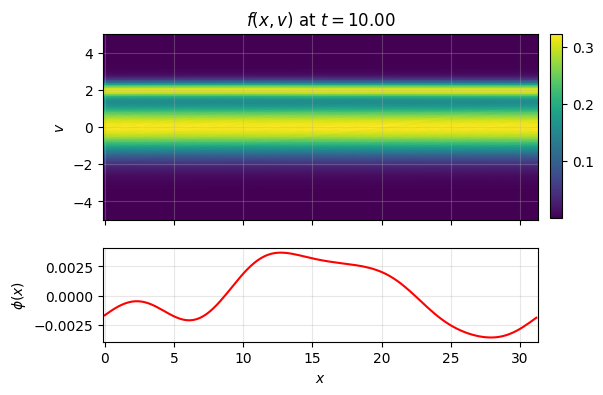

t ≈ 15.00, index = 30


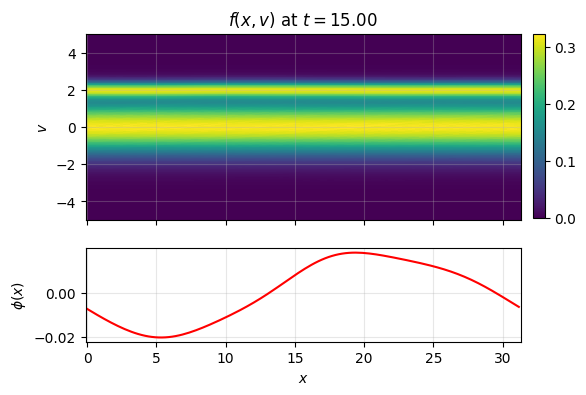

In [2]:
def plot_phase_and_phi(fvx, phi, t, x, v):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True,
                                   gridspec_kw={'height_ratios': [2, 1]})
    plt.subplots_adjust(right=0.85)  # reserve space for colorbar

    pcm = ax1.pcolormesh(x, v, fvx, shading='auto', cmap='viridis')
    ax1.set_ylabel(r"$v$")
    ax1.set_title(r"$f(x,v)$ at $t=$"+f"{t:.2f}")
    ax1.grid(True, alpha=0.3)
    cbar_ax = fig.add_axes([0.87, 0.42, 0.02, 0.46])  # [left, bottom, width, height]
    cbar = fig.colorbar(pcm, cax=cbar_ax)

    ax2.plot(x, phi, 'r')
    ax2.set_xlabel(r"$x$")
    ax2.set_ylabel(r"$\phi(x)$")
    ax2.grid(True, alpha=0.3)

    plt.show()


for t_plot in [0.0, 10.0, 15.0]:
    idx = np.argmin(np.abs(t_all - t_plot))
    print(f"t ≈ {t_all[idx]:.2f}, index = {idx}")
    plot_phase_and_phi(f_all[idx], field_all[1][idx], t_all[idx], x, v)


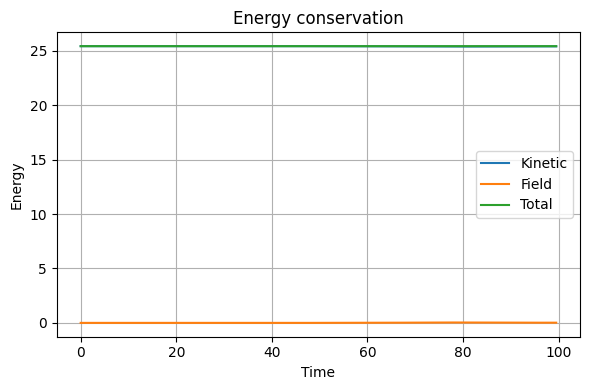

In [3]:
# --- Plot energy conservation ---
dx = x[1] - x[0]
dv = v[1] - v[0]
kinetic_energy = 0.5 * np.sum(f_all * v[None, :, None]**2, axis=(1, 2)) * dx * dv
field_energy = 0.5 * np.sum(field_all[2]**2, axis=1) * dx
total_energy = kinetic_energy + field_energy

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()
ax.plot(t_all, kinetic_energy, label="Kinetic")
ax.plot(t_all, field_energy, label="Field")
ax.plot(t_all, total_energy, label="Total")
ax.set_xlabel("Time")
ax.set_ylabel("Energy")
ax.set_title("Energy conservation")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# --- Animation ---
f_plot = f_all  # or f_all - f0[None, :, :] for delta-f

# --- Reserve space for external colorbar ---
fig, axs = plt.subplots(2, 1, figsize=(6, 4), sharex=True,
                        gridspec_kw={'height_ratios': [2, 1]})
plt.subplots_adjust(right=0.85)  # leave space on the right for colorbar

# --- Create pcolormesh and colorbar in independent axis ---
pcm = axs[0].pcolormesh(x, v, f_plot[0], shading='auto', cmap='viridis')
cbar_ax = fig.add_axes([0.87, 0.42, 0.02, 0.46])  # [left, bottom, width, height]
cbar = fig.colorbar(pcm, cax=cbar_ax)

# --- phi(x) line ---
line_phi, = axs[1].plot(x, field_all[1][0], color='r')

# --- Axis labels and limits ---
axs[0].set_ylabel(r"$v$")
axs[0].set_title(r"$f(x,v)$ at $t=$"+f"{t_all[0]:.2f}")
axs[1].set_ylabel(r"$\phi(x)$")
axs[1].set_xlabel(r"$x$")
axs[1].set_ylim(np.min(field_all[1]), np.max(field_all[1]))

# --- Update function for animation ---
def update(i):
    pcm.set_array(f_plot[i].ravel())
    pcm.set_clim(vmin=np.min(f_plot[i]), vmax=np.max(f_plot[i]))
    cbar.update_normal(pcm)
    line_phi.set_ydata(field_all[1][i])
    axs[0].set_title(r"$f(x,v)$ at $t=$"+f"{t_all[i]:.2f}")
    return pcm, line_phi

# --- Create and save animation ---
ani = FuncAnimation(fig, update, frames=range(0, len(t_all), 1), interval=50, blit=True)
ani.save("vlasov_phase_phi.mp4", writer="ffmpeg", fps=20)
plt.close()

# --- Display in notebook ---
Video("vlasov_phase_phi.mp4", embed=True)